## Living Planet Symposium 2022 Training Session
# Leverage Euro Data Cube services for accessing, analysing and visualising EO data
---
**Original JN:** _Exploring Time and Space: A guide to accessing, analysing and visualising data in the Euro Data Cube_

**Author original JN:** _William Ray_

**Edited and extended by:** _Alicja Balfanz_ & _Max Kampen_

## Getting started with EDC

In this demonstration Jupyter Notebook, we will be visualising and analysing a flooding event using Sentinel data to demonstrate how you can use EDC for your own applications. Much of what we we will focus on can be used for many other applications and use cases.

We are going to use EDC with its associated libaries and APIs to do this. In this notebook we will learn how to:

- Build a data cube
- Create a new variable
- Visualise a variable of your data cube
- Create a new variable using a threshold
- Visualise a spatial subset of a variable over time
- Create a new variable based upon space and time

## Configuration

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace), and fetch pre-generated credentials as environment variables to access the services.

In [1]:
# Check compatibility and import environment credentials
from edc import check_compatibility
check_compatibility("user-2022.02", dependencies=["GEODB", "SH"])

# EDC libraries
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
from xcube.core.geom import mask_dataset_by_geometry

# Sentinel Hub
from sentinelhub import BBox

# Utilities
import IPython.display
import matplotlib.pyplot as plt
import datetime as dt
import rioxarray
import shapely

# Numerical computation
import xarray as xr
import numpy as np



---------

The following environment variables are available:

* `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_DOMAIN`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_API_SERVER_PORT`
* `SH_CLIENT_ID`, `SH_INSTANCE_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`


## Define an AOI

Next, we will define our area of interest using a bounding box. For our example we will use WGS84 coordinates to build the data cube. We have chosen an AOI that covers Madagascar's capital city Antananarivo and surrounding regions. In early 2022, the east coast of Madagascar was impacted by two different tropical weather systems, which caused heavy rainfall and flooding in the country's capital and Analamanga region ([source](https://reliefweb.int/report/madagascar/madagascar-rainy-and-cyclone-season-flash-update-no1-24-january-2022)). Across Madagascar, the heavy rainfall persisted throughout January and February, when the moderate tropical storm _Ana_ and the tropical cyclone _Batsirai_ made landfall in January and Februrary respectively ([source](https://www.worldweatherattribution.org/climate-change-increased-rainfall-associated-with-tropical-cyclones-hitting-highly-vulnerable-communities-in-madagascar-mozambique-malawi/)).

In [2]:
# Bbox
Antananarivo_bbox = [47.221985, -19.129599, 47.671051, -18.659257]

# Bbox EPSG
bbox_epsg = 4326

In [3]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(Antananarivo_bbox,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

## How to build a data cube

Firstly, we will go through the required steps to build a data cube.

We are going to visualise the flooding events using Sentinel-2 imagery. The Sentinel-2 system (consisting of two twin satellites) is part of the Copernicus programme and collects multispectral data globally with a revisit time of 5 days. The satellite's multispectral imager acquires data in 13 spectral bands spanning from the visible and near infrared to shortwave infrared.

### Check available Sentinel-2 L2A bands

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset to help us build the cube!

In [4]:
# Create a Sentinel Hub class
SH = SentinelHub()

# List bands for S2-L2A
SH.band_names('S2L2A')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'SCL',
 'SNW',
 'CLD',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'AOT',
 'CLM',
 'CLP']

### Build an xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S2L2A` for Sentinel-2 L2A. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call the B02, B03, B04, B08, CLM (Blue, Green, Red & NIR, Cloud Mask) bands.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 30 meters, we set the resolution to 0.00045 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-2 L2A data is available from October 2016 onwards. In this example, we will fetch data for January 2022 through March 2022.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [5]:
# Setup xcube
s2_cube_config = CubeConfig(dataset_name='S2L2A',
                            band_names=['B02', 'B03', 'B04', 'B08', 'CLM'],
                            bbox=Antananarivo_bbox,
                            spatial_res=0.00045,
                            time_range=['2022-01-01', '2022-04-01'],
                            time_tolerance='30M')

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:148: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we open the cube and display its contents. It's important to note that at this stage, we're not processing anything, but generate a cube on the fly with data ready to be called when needed for analysis.

Once you open the cube, you can visualise the contents. For example, you can view the number of timestamps as a list in the Coordinates tab. You can also visualise the seperate variables, with information on their size and data type.

In [6]:
# Open cube (on the fly)
s2_cube = open_cube(s2_cube_config)

# Display contents
s2_cube

<xarray.Dataset>
Dimensions:    (time: 36, lat: 1045, lon: 998, bnds: 2)
Coordinates:
  * lat        (lat) float64 -18.66 -18.66 -18.66 ... -19.13 -19.13 -19.13
  * lon        (lon) float64 47.22 47.22 47.22 47.22 ... 47.67 47.67 47.67 47.67
  * time       (time) datetime64[ns] 2022-01-03T07:14:49 ... 2022-03-31T07:04:55
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(36, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-05-19T16:40:19.928839
    time_coverage_start:     2022-01-03T07:14:43+00:00
    time_coverage_end:       2022-03-31T07:05:02+00:00
    time_coverage_duration:  P86DT23H50M19S
    geospatial_lon_min:      47.221985
    geospatial_lat_min:      -19.129599
    geospatial_lon_max:      47.671085
    geospatial_lat_max:      -18.659349
    processing_level:        L2A

### Create a new variable

A great way to visualise the extent of surface water with multispectral data at hand, is to use the Normalised Difference Water Index (NDWI). We can calculate the index with the Green and NIR bands as stated below, and add it to the data cube as a new variable.

NDWI = Green - NIR / Green + NIR

For this, we are going to create a new variable in the next cell. To create the new variable we are using two existing variables defined as s2.cube.B03 and s2_cube.B08. We then insert these variables into an index formula to calculate our `ndwi` variable. To integrate the new varibale into our data cube, we first need to define a new empty data cube attribute, provided with a name and associated units, before assigning the calculated `ndwi` variable to it. Feel free to call `s2_cube` again to check the newly added variable that can now be called from the data cube.

In [7]:
# Define NDWI in visualisation
ndwi = ((s2_cube.B03-s2_cube.B08)/(s2_cube.B03+s2_cube.B08))

ndwi.attrs['long_name'] = 'NDWI'
ndwi.attrs['units'] ='unitless'

s2_cube['NDWI'] = ndwi
s2_cube

<xarray.Dataset>
Dimensions:    (time: 36, lat: 1045, lon: 998, bnds: 2)
Coordinates:
  * lat        (lat) float64 -18.66 -18.66 -18.66 ... -19.13 -19.13 -19.13
  * lon        (lon) float64 47.22 47.22 47.22 47.22 ... 47.67 47.67 47.67 47.67
  * time       (time) datetime64[ns] 2022-01-03T07:14:49 ... 2022-03-31T07:04:55
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(36, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    NDWI       (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-05-19T16:40:19.928839
    time_coverage_start:     2022-01-03T07:14:43+00:00
    time_coverage_end:       2022-03-31T07:05:02+00:00
    time_coverage_duration:  P86DT23H50M19S
    geospatial_lon_min:      47.221985
    geospatial_lat_min:      -19.129599
    geospatial_lon_max:      47.671085
    geospatial_lat_max:      -18.659349
    processing_level:        L2A

## How to visualise your datacube

### Visualise variables

We are going to visualise a True Color image and the NDWI image in the same plot. For the True Color image, we select the Blue, Green and RED bands for one timstamp in the data cube in order to create a multiband RGB image stack. For visualisation purposes, we will multiply the reflectance values by 3 to brighten the image a little. We also fetch the NDWI variable for the exact same date for a side-by-side comparison.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


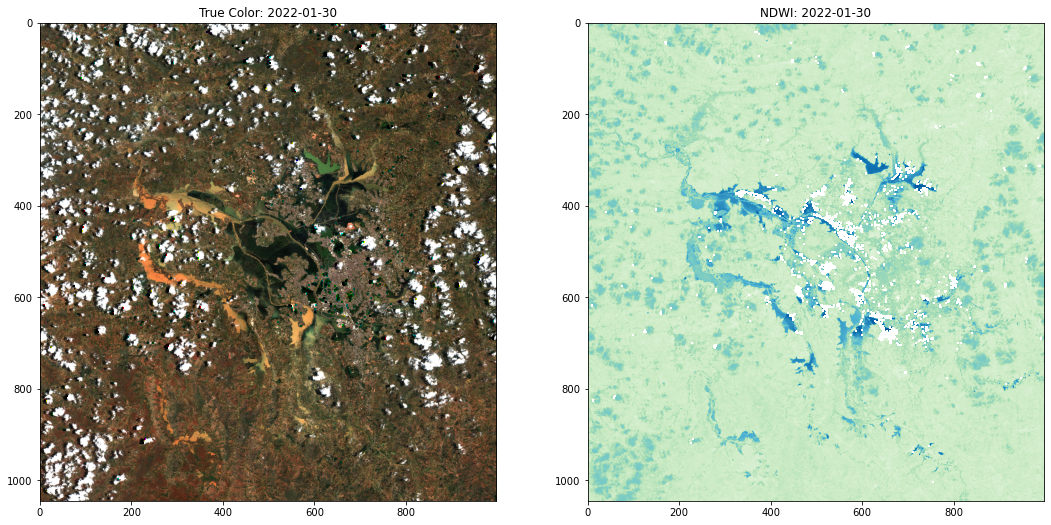

In [8]:
# Select timestamp
t = '2022-01-30 07:00:00'

# Select the bands and stack them.
Red = s2_cube.B04.sel(time=t, method='nearest')
Green = s2_cube.B03.sel(time=t, method='nearest')
Blue = s2_cube.B02.sel(time=t, method='nearest')

rgb = np.dstack((Red,Green,Blue)) #Stack the three arrays

ndwi = s2_cube.NDWI.sel(time=t, method='nearest')

# Plot 
f = plt.figure(figsize=[18, 16])
f.add_subplot(1, 2, 1)
plt.title(f"True Color: {str(s2_cube.time.sel(time=t, method='nearest').data).split('T')[0]}")
plt.imshow(3 * rgb)  # We multiply the rgb by 3 to make the image brighter
f.add_subplot(1, 2, 2)
plt.title(f"NDWI: {str(s2_cube.time.sel(time=t, method='nearest').data).split('T')[0]}")
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='GnBu')
plt.show()

### Visualise multiple timestamps

We would like to get a better idea of the course of events and examine how the two storm weather systems affected the area. The flooding events we are trying to monitor happened in the middle of the Southwest Indian Ocean cyclone season, which approximately lasts from November until April. In order to check how many suitable Sentinel-2 acquisitions we have at hand, we will take a look at multiple timestamps from the data cube.

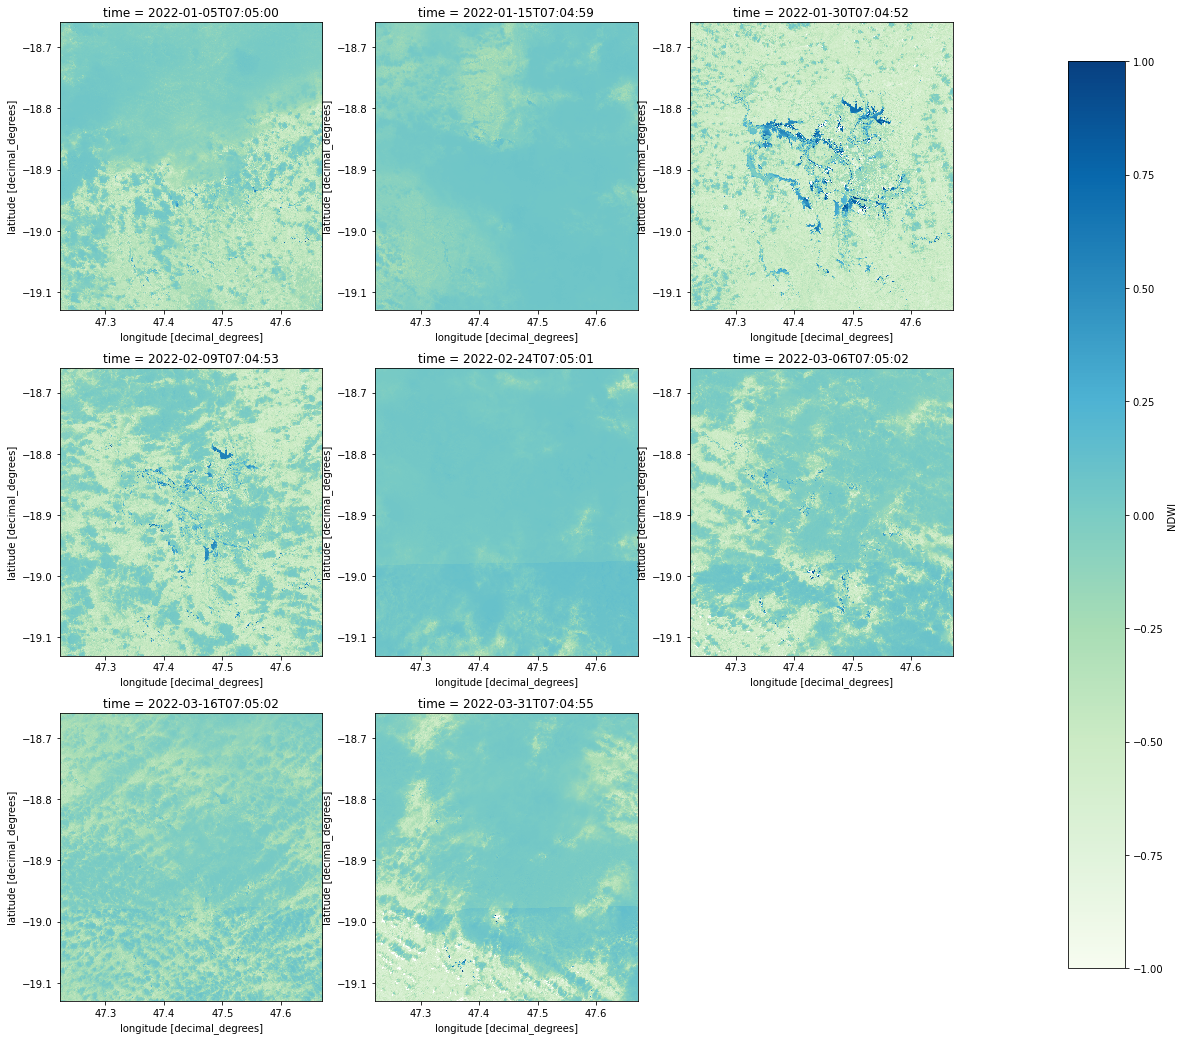

In [9]:
# Select timestamps
ndwi1 = s2_cube.NDWI.sel(time='2022-01-05 07:00:00', method='nearest')
ndwi2 = s2_cube.NDWI.sel(time='2022-01-15 07:00:00', method='nearest')
ndwi3 = s2_cube.NDWI.sel(time='2022-01-30 07:00:00', method='nearest')
ndwi4 = s2_cube.NDWI.sel(time='2022-02-09 07:00:00', method='nearest')
ndwi5 = s2_cube.NDWI.sel(time='2022-02-24 07:00:00', method='nearest')
ndwi6 = s2_cube.NDWI.sel(time='2022-03-06 07:00:00', method='nearest')
ndwi7 = s2_cube.NDWI.sel(time='2022-03-16 07:00:00', method='nearest')
ndwi8 = s2_cube.NDWI.sel(time='2022-03-31 07:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[16, 18])
ax1 = f.add_subplot(3, 3, 1)
ax2 = f.add_subplot(3, 3, 2)
ax3 = f.add_subplot(3, 3, 3)
ax4 = f.add_subplot(3, 3, 4)
ax5 = f.add_subplot(3, 3, 5)
ax6 = f.add_subplot(3, 3, 6)
ax7 = f.add_subplot(3, 3, 7)
ax8 = f.add_subplot(3, 3, 8)

axlist = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

t = ndwi1.plot.imshow(ax=ax1, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi2.plot.imshow(ax=ax2, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi3.plot.imshow(ax=ax3, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi4.plot.imshow(ax=ax4, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi5.plot.imshow(ax=ax5, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi6.plot.imshow(ax=ax6, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi7.plot.imshow(ax=ax7, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)
ndwi8.plot.imshow(ax=ax8, vmin=-1, vmax=1, cmap='GnBu', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="NDWI")

plt.show()

Unsurprisingly, the weather conditions during storm season are not suitable for Earth monitoring with optical imagery. Of the eight dates we have requested, only one, the acquisition from 30th January, is not completely overcast and the remaining ones are unusable. Fortunately, we can resort to using Sentinel-1 GRD radar data, which is unimpeded by weather conditions and should provide a better picture of the course of events.

---

## Buildind a Sentinel-1 data cube

The Sentinel-1 satellite system is also part of the Copernicus programme and collects data globally with a revisit time of 5 days when both twin satellites are active. Unfortunately, the recent failure of Sentinel-1B leaves us with longer revisit times ([source](https://scihub.copernicus.eu/news/News01026)). In contrast to Sentinel-2, Sentinel-1 SAR is an active sensor that sends SAR signals and records the backscatter. Due to the wavelengths used, SAR is not hindered by clouds and can be operated day and night. 

### Check Sentinel-1 GRD available bands

Using EDC inbuilt functions that query Sentinel Hub services, we can easily list the available bands for a given dataset. 

In [10]:
# List bands for S1-GRD
SH.band_names('S1GRD')

['VV', 'HH', 'VH', 'localIncidenceAngle', 'scatteringArea', 'shadowMask', 'HV']

### Build the S-1 GRD xcube

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _dataset_name_: the Sentinel Hub identification of the dataset. Here we will call `S1GRD` for Sentinel-1 GRD. All available datasets can be listed with `SH.dataset_names`

- _band_names_: the band names to be used in the xcube array (see previous code cell). Here, we will call just the VV polarisation band.

- _bbox_: the bounding box that sets the extent of the AOI. Because we are using the default WGS84 coordinate system here, the CRS parameter doesn't need to be set.

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 30 meters, we set the resolution to 0.00045 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. Sentinel-1 GRD data is available from February 2015 onwards. In this example, we will fetch data for January 2022 through March 2022.

- _time_tolerance_: The tolerance used to identify whether a dataset should still be included within a time period. Here, `30M` corresponds to 30 minutes, thus avoiding duplicate datasets.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [11]:
# Setup xcube
s1_cube_config = CubeConfig(dataset_name='S1GRD',
                            band_names=['VV'],
                            bbox=Antananarivo_bbox,
                            spatial_res=0.00045,
                            time_range=['2022-01-01', '2022-04-01'],
                            time_tolerance='30M')

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:148: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### Open the xcube

In the following cell we pass the configurated cube to the open cube command to open the cube and display its contents.

In [12]:
# Open cube (on the fly)
s1_cube = open_cube(s1_cube_config)

# Display contents
s1_cube

<xarray.Dataset>
Dimensions:    (time: 8, lat: 1045, lon: 998, bnds: 2)
Coordinates:
  * lat        (lat) float64 -18.66 -18.66 -18.66 ... -19.13 -19.13 -19.13
  * lon        (lon) float64 47.22 47.22 47.22 47.22 ... 47.67 47.67 47.67 47.67
  * time       (time) datetime64[ns] 2022-01-03T02:19:35 ... 2022-03-28T02:19:33
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-05-19T16:40:45.536011
    time_coverage_start:     2022-01-03T02:19:35+00:00
    time_coverage_end:       2022-03-28T02:19:33+00:00
    time_coverage_duration:  P83DT23H59M58S
    geospatial_lon_min:      47.221985
    geospatial_lat_min:      -19.129599
    geospatial_lon_max:      47.671085
    geospatial_lat_max:      -18.659349
    processing_level:        L1B

### Visualising the flooded areas using SAR

Firstly, we need to generate a new variable. For Sentinel-1 data, the values are returned in linear power. For a more convenient analysis we will convert the values to decibels. This is done by mutiplying the log10 of each pixel value by 10. Secondly, as there will be pixels with a value of -inf after this operation, we need to account for this with the second function that will automatically assign 0 to these pixels.

In [13]:
# Convert VV Digital numbers to Decibels
vv_dn = s1_cube.VV
vv_db = 10 * (np.log10(vv_dn))

vv_db = vv_db.where(np.isfinite(vv_db), 0)

vv_db.attrs['long_name'] = 'VV_dB'
vv_db.attrs['units'] = 'decibels'

s1_cube['VV_dB'] = vv_db

From the news and our previous visualisation of Sentinel-2 data, we know that there was significant surface water flooding in January and February 2022. Let's visualise one of the acquisitions from the end of January, when the tropical storm _Ana_ brought heavy rainfall to the area. Here, we select the closest acquisition to 25th January 2022 and plot the calculated `VV_dB` variable for our region of interest.

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


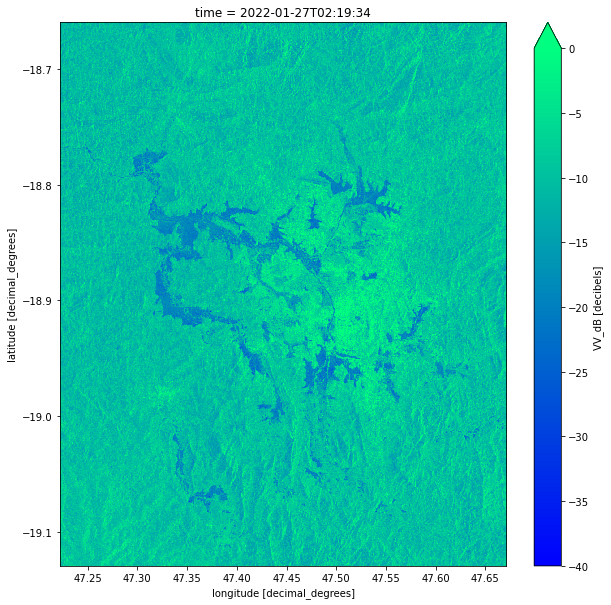

In [14]:
# select and define the timestamp you want to visualise 
VV_dB_timestamp = s1_cube.VV_dB.sel(time='2022-01-25 07:00:00', method='nearest')

# plot the timestamp
VV_dB_timestamp.plot.imshow(vmin=-40, vmax=0, cmap='winter', figsize=(10, 10))

# save and display the plot
plt.show()

On this Sentinel-1 acquisition from 27th January, we can clearly see the extent of flooded areas in darker blue colour. The visualisation already looks fairly well defined, so let's plot multiple timestamps to confirm that this is a good variable for generating subsequent products like flood masks.

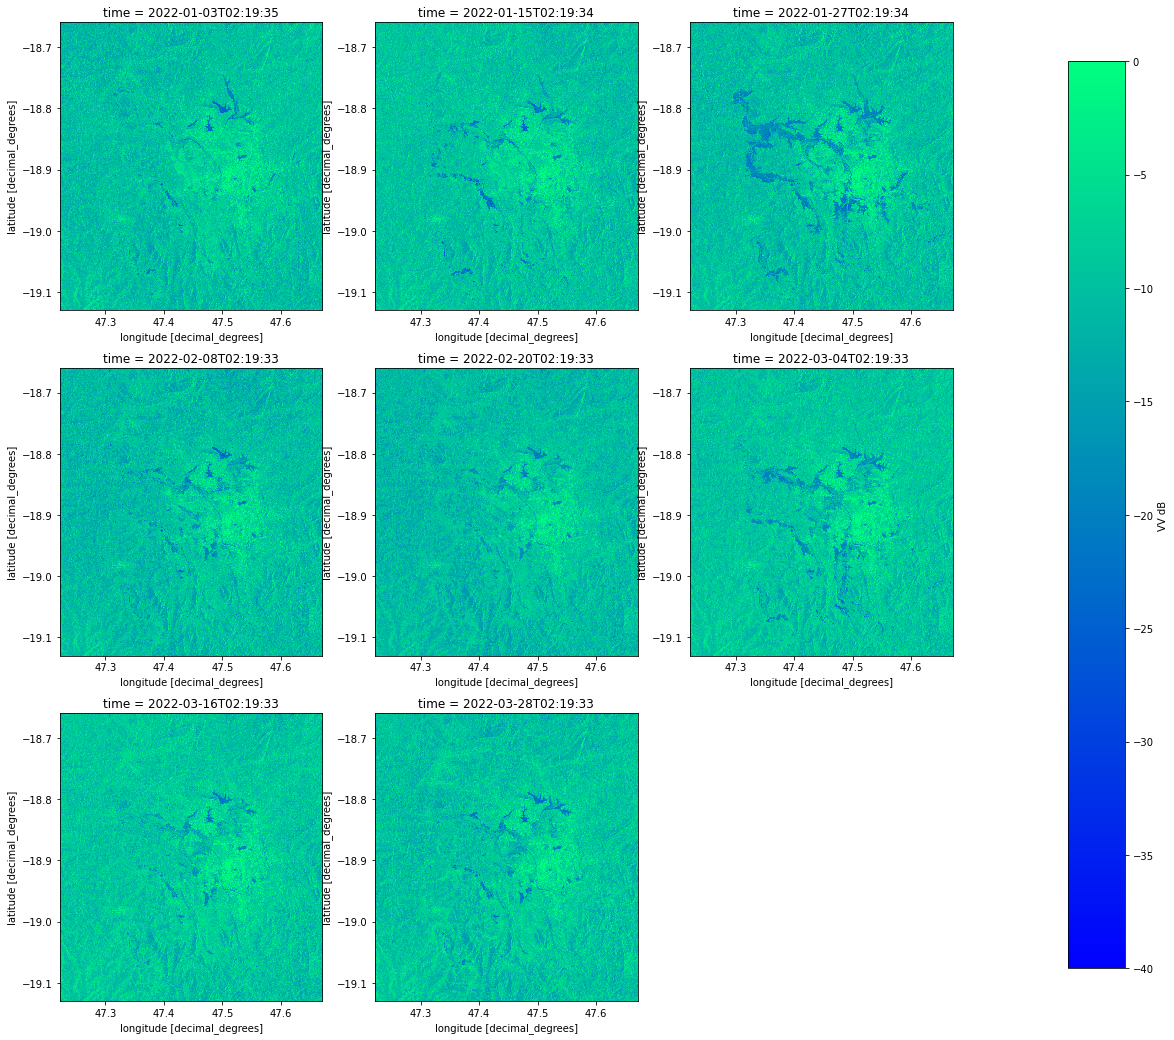

In [15]:
#### Timestamp selection
vv1 = s1_cube.VV_dB.sel(time='2022-01-03 07:00:00', method='nearest')
vv2 = s1_cube.VV_dB.sel(time='2022-01-15 07:00:00', method='nearest')
vv3 = s1_cube.VV_dB.sel(time='2022-01-27 07:00:00', method='nearest')
vv4 = s1_cube.VV_dB.sel(time='2022-02-08 07:00:00', method='nearest')
vv5 = s1_cube.VV_dB.sel(time='2022-02-20 07:00:00', method='nearest')
vv6 = s1_cube.VV_dB.sel(time='2022-03-04 07:00:00', method='nearest')
vv7 = s1_cube.VV_dB.sel(time='2022-03-16 07:00:00', method='nearest')
vv8 = s1_cube.VV_dB.sel(time='2022-03-28 07:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[16, 18])
ax1 = f.add_subplot(3, 3, 1)
ax2 = f.add_subplot(3, 3, 2)
ax3 = f.add_subplot(3, 3, 3)
ax4 = f.add_subplot(3, 3, 4)
ax5 = f.add_subplot(3, 3, 5)
ax6 = f.add_subplot(3, 3, 6)
ax7 = f.add_subplot(3, 3, 7)
ax8 = f.add_subplot(3, 3, 8)

axlist = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

t = vv1.plot.imshow(ax=ax1, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv2.plot.imshow(ax=ax2, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv3.plot.imshow(ax=ax3, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv4.plot.imshow(ax=ax4, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv5.plot.imshow(ax=ax5, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv6.plot.imshow(ax=ax6, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv7.plot.imshow(ax=ax7, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)
vv8.plot.imshow(ax=ax8, vmin=-40, vmax=0, cmap='winter', add_colorbar=False)

cbar_ax = f.add_axes([1, 0.15, 0.05, 0.7])
f.colorbar(t, cax=cbar_ax, label="VV dB")

plt.show()

This gives us a much clearer picture of the spatial and temporal extent of the flooding events in the region. We can make out two flooding peaks in the acquisitons from 27th January and 4th March, which are congruent with the reports on the two storms making landfall.

### Creating a flood mask

Next, we want to generate a flood mask using a threshold for the `VV_dB` variable. In VV polarization mode, values below -20 dB are usually surface water. Let's define different thresholds for a side-by-side comparison in order to find the most suitable value for generating the flood mask.

In [16]:
flood_threshold1_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -15, 1)
flood_threshold2_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -18, 1)
flood_threshold3_step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -20, 1)

flood_threshold1_step2 = flood_threshold1_step1.where(flood_threshold1_step1 == 1, 0)
flood_threshold2_step2 = flood_threshold2_step1.where(flood_threshold2_step1 == 1, 0)
flood_threshold3_step2 = flood_threshold3_step1.where(flood_threshold3_step1 == 1, 0)

flood_threshold1 = flood_threshold1_step2.sel(time='2022-01-27 07:00:00', method='nearest')
flood_threshold2 = flood_threshold2_step2.sel(time='2022-01-27 07:00:00', method='nearest')
flood_threshold3 = flood_threshold3_step2.sel(time='2022-01-27 07:00:00', method='nearest')

Next we will plot the new thresholds we want to test:

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


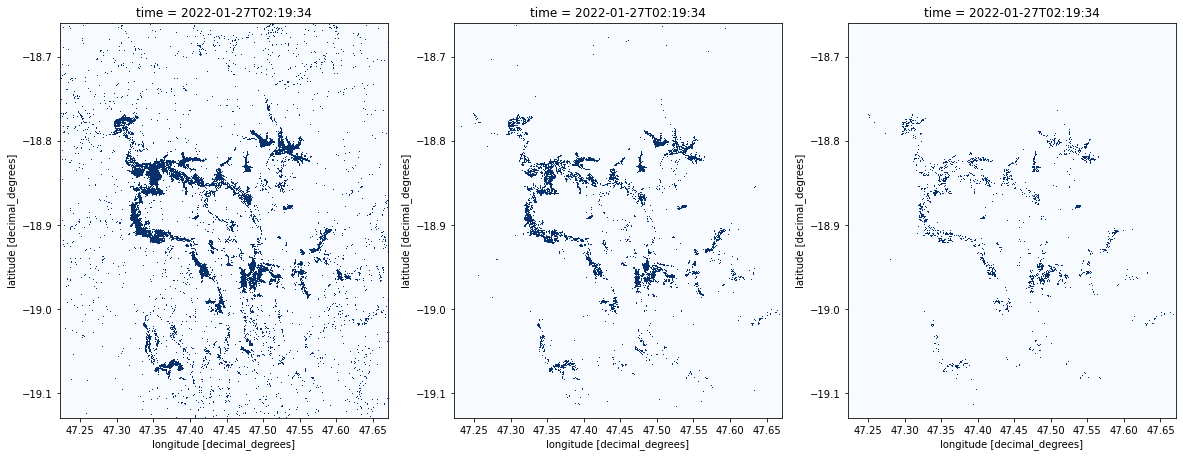

In [17]:
# Plot 
f = plt.figure(figsize=[20, 16])
ax1 = f.add_subplot(2, 3, 1)
ax2 = f.add_subplot(2, 3, 2)
ax3 = f.add_subplot(2, 3, 3)

flood_threshold1.plot.imshow(ax=ax1, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
flood_threshold2.plot.imshow(ax=ax2, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
flood_threshold3.plot.imshow(ax=ax3, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)

plt.show()

Changing the threshold by only 2 or 3 dB makes a large difference. If we set a higher threshold, we pick up a lot more false positives. With a lower threshold, we start to create more false negatives and a more fragmented flood extent. Based on the visualisation above, we will use -18 dB as the threshold.

Let's add the flood mask variable to our Sentinel-1 data cube. At first glance, the below cell may not make much sense. The definition of variable `step1` could be interpreted as assigning a value of 1 to pixels that are equal or more than -18 dB. However, what is actually happening is that the `.where` method preserves all the pixel values of the variable that are below -18 dB and assigns everything else a value of 1. More detailed information on the method can be found in the [respective xarray documentation](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html).

In [18]:
# Assign all pixels equal or smaller than -18 a value of 1 and preserve the values of pixels 
step1 = s1_cube.VV_dB.where(s1_cube.VV_dB >= -18, 1)

# Assign all other pixels a value of 0. 
flooded = step1.where(step1 == 1, 0)

flooded.attrs['long_name'] = 'flood_mask'
flooded.attrs['units'] = 'nounits'

s1_cube['flood_mask'] = flooded
s1_cube

<xarray.Dataset>
Dimensions:     (time: 8, lat: 1045, lon: 998, bnds: 2)
Coordinates:
  * lat         (lat) float64 -18.66 -18.66 -18.66 ... -19.13 -19.13 -19.13
  * lon         (lon) float64 47.22 47.22 47.22 47.22 ... 47.67 47.67 47.67
  * time        (time) datetime64[ns] 2022-01-03T02:19:35 ... 2022-03-28T02:1...
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    VV          (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    VV_dB       (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    flood_mask  (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-05-19T16:40:45.536011
    time_coverage_start:     2022-01-03T02:19:35+00:00
    time_coverage_end:       2022-03-28T02:19:33+00:00
    time_coverage_duration:  P83DT23H59M58S
    geospatial_lon_min:      47.221985
    geospatial_lat_min:      -19.129599
    geospatial_lon_max:      47.671085
    geospatial_lat_max:      -18.659349
    processing_level:        L1B

Let's plot the generated flood mask over multiple timestamps again:

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


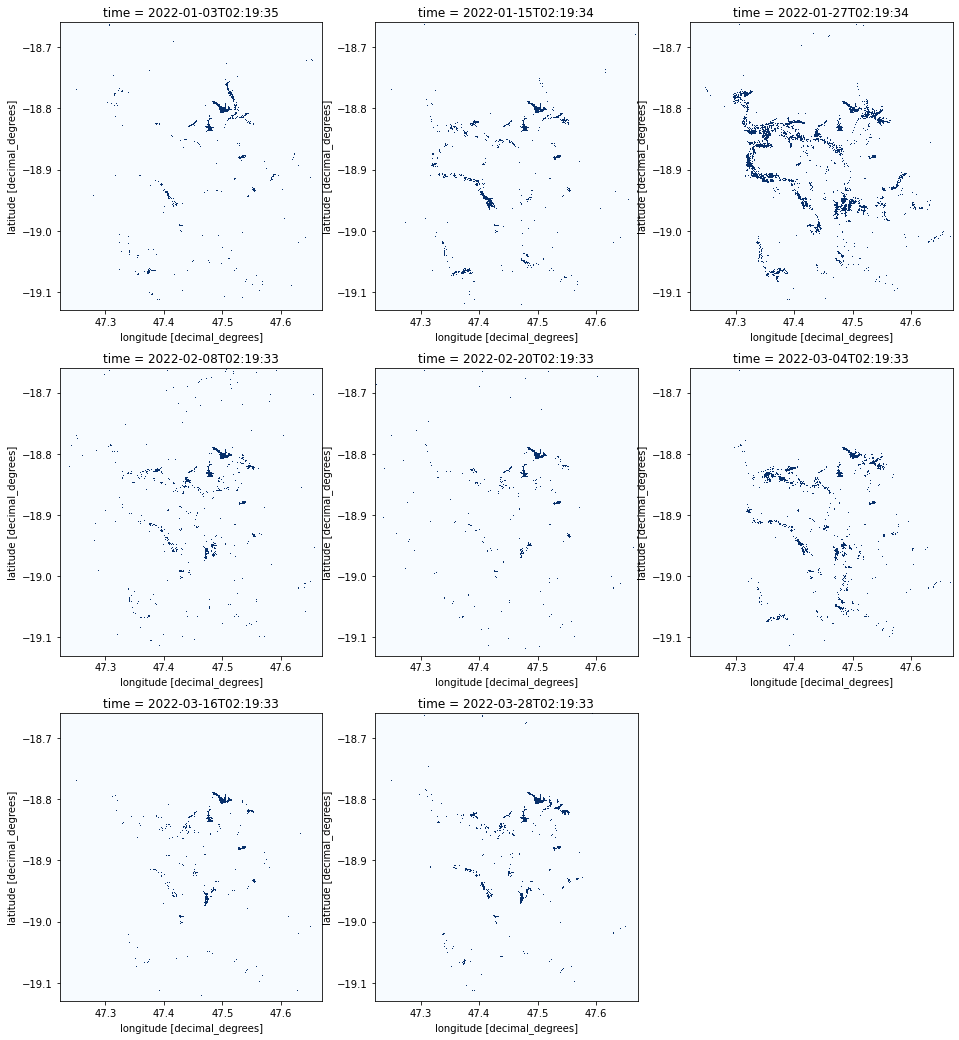

In [19]:
#### Timestamp selection
fm1 = s1_cube.flood_mask.sel(time='2022-01-03 07:00:00', method='nearest')
fm2 = s1_cube.flood_mask.sel(time='2022-01-15 07:00:00', method='nearest')
fm3 = s1_cube.flood_mask.sel(time='2022-01-27 07:00:00', method='nearest')
fm4 = s1_cube.flood_mask.sel(time='2022-02-08 07:00:00', method='nearest')
fm5 = s1_cube.flood_mask.sel(time='2022-02-20 07:00:00', method='nearest')
fm6 = s1_cube.flood_mask.sel(time='2022-03-04 07:00:00', method='nearest')
fm7 = s1_cube.flood_mask.sel(time='2022-03-16 07:00:00', method='nearest')
fm8 = s1_cube.flood_mask.sel(time='2022-03-28 07:00:00', method='nearest')

# Plot 
f = plt.figure(figsize=[16, 18])
ax1 = f.add_subplot(3, 3, 1)
ax2 = f.add_subplot(3, 3, 2)
ax3 = f.add_subplot(3, 3, 3)
ax4 = f.add_subplot(3, 3, 4)
ax5 = f.add_subplot(3, 3, 5)
ax6 = f.add_subplot(3, 3, 6)
ax7 = f.add_subplot(3, 3, 7)
ax8 = f.add_subplot(3, 3, 8)

axlist = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

t = fm1.plot.imshow(ax=ax1, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm2.plot.imshow(ax=ax2, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm3.plot.imshow(ax=ax3, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm4.plot.imshow(ax=ax4, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm5.plot.imshow(ax=ax5, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm6.plot.imshow(ax=ax6, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm7.plot.imshow(ax=ax7, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)
fm8.plot.imshow(ax=ax8, vmin=0, vmax=1, cmap='Blues', add_colorbar=False)

plt.show()

Despite the flood mask containing some noise, the chosen threshold looks adequate across time and space. Let's move on to visualising the data from the temporal point of view.

## How to generate a time series plot for a point

We now have a really good picture of how the flooding evolved over space and time. Following this, we want to monitor a specific point location within the AOI and observe how NDWI and then VV_dB variables in the cubes compare over time. Firstly, we define the point's coordinates with `point_lat` and `point_lon`. These are used as inputs when we select the variables accross all available timestamps with the help of the `.to_series()` method. It's at this point too that we use the CLM variable to mask out cloudy areas from the Sentinel 2 acquisitions in the time steps.

In [20]:
# Set latitude and longitude of point to query
point_lat = -18.96377
point_lon = 47.48737

In [21]:
# Get timeseries
masked = s2_cube.NDWI.where(s2_cube.CLM == 0)
timeseriesNDWI_masked = masked.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesNDWI_masked = timeseriesNDWI_masked.where(timeseriesNDWI_masked !=0).dropna()

timeseriesNDWI = s2_cube.NDWI.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesNDWI = timeseriesNDWI.where(timeseriesNDWI !=0).dropna()

### Plot NDWI time series for a given point location

Using matplotlib we can now visualise how NDWI changes over time. In the plot we will plot 2 series, a cloud-masked series in blue, and an unmasked series in grey. 

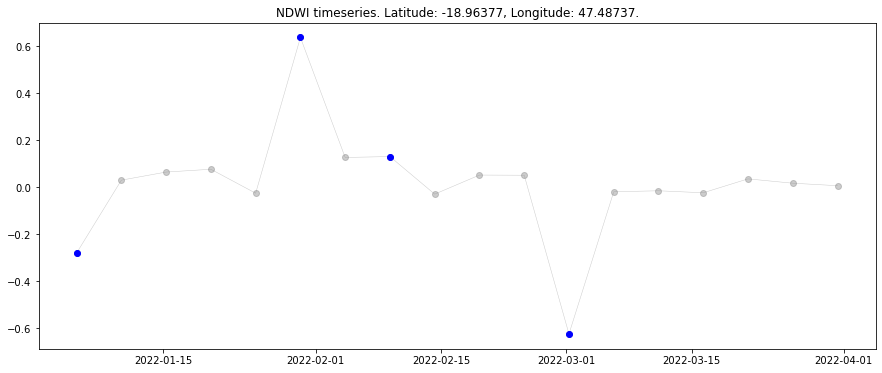

In [22]:
# Plot NDWI timeseries
_, ax = plt.subplots(1, figsize=(15, 6))
ax.plot(timeseriesNDWI, color="Grey", marker="o", linewidth=0.5, alpha=0.4)
ax.plot(timeseriesNDWI_masked, color="blue", linestyle="none", marker="o", linewidth=0.5)
ax.set_title(f"NDWI timeseries. Latitude: {point_lat}, Longitude: {point_lon}.")
plt.show()

The NDWI time series for Sentinel-2 doesn't really show us anything significant. There is no farily consistent NDWI value to go from which makes it difficult to establish a point of reference. There are peaks in NDWI at the end of December and the start of February but as was demonstrated earlier cloud cover is a big issue. There are big gaps between non-cloudy acquisitions of over a month in some cases. Let's plot the same but for the VV polarisation from Sentinel-1. 

### Plot VV dB timeseries for a given point location

We can now visualise how VV dB changes over time.

In [23]:
# Get timeseries
timeseriesVV_dB = s1_cube.VV_dB.sel(lat=point_lat, lon=point_lon, method='nearest').to_series()
timeseriesVV_dB = timeseriesVV_dB.where(timeseriesVV_dB !=0).dropna()

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


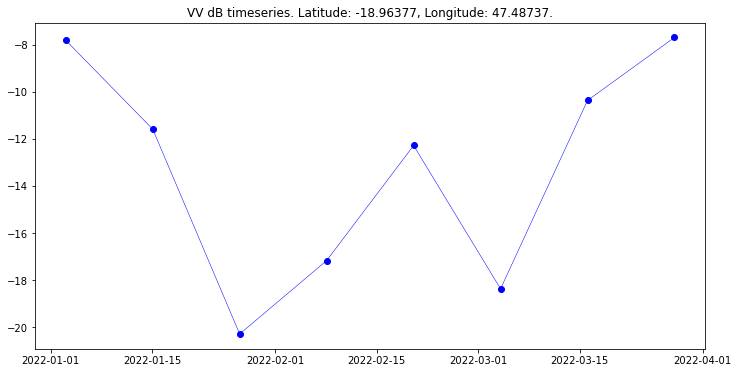

In [24]:
# Plot VV_dB timeseries
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(timeseriesVV_dB, color="blue", marker="o", linewidth=0.5)
ax.set_title(f"VV dB timeseries. Latitude: {point_lat}, Longitude: {point_lon}.")
plt.show()

This is much clearer than the Sentinel 2 time series as we have more observations due to no interference from cloud cover. We have a clear point of reference for what the VV polarisation response is during flood and non flooded time periods with a VV response of -8 to 0 dB when dry and < - dB when flooded. The time series really clearly shows the two flood events at the end of January and February.

### Plot VV dB timeseries for a given AOI polygon

Let's take this another step further, and generate the time series using a polygon instead of a point. For this we can use for example the administrative regions of Madagaskar, which are included into the geoDB ([source](https://data.humdata.org/dataset/cod-ab-mdg)).

To be able to use data from the geoDB, we need to instantiate a geoDB client.

In [25]:
from xcube_geodb.core.geodb import GeoDBClient
geodb = GeoDBClient()

To see, what geoDB role we have, we can ask who I am. You will see a different id in your workspace. 

In [26]:
geodb.whoami

'geodb_418dfeac-15f0-4606-9edb-fd9eb722bf04'

Different resoulution of administrative boundaries of Madagaskar are in the database called "madagascar_adm_boundaries". Let's have a look how many different collections we have:

In [27]:
geodb.get_my_collections(database="madagascar_adm_boundaries")

owner                   database collection table_name
0  geodb_admin  madagascar_adm_boundaries       adm0       adm0
1  geodb_admin  madagascar_adm_boundaries       adm1       adm1
2  geodb_admin  madagascar_adm_boundaries       adm2       adm2
3  geodb_admin  madagascar_adm_boundaries       adm3       adm3
4  geodb_admin  madagascar_adm_boundaries       adm4       adm4

Let's have a look, what is in the adm1 collection:

In [28]:
adm1 = geodb.get_collection_pg("adm1", database="madagascar_adm_boundaries")

We want to get a brief idea of the data inside the collection, so we print out the first few lines of the data

In [29]:
adm1.head()

id                        created_at modified_at  \
0   1  2022-04-29T12:29:10.323348+00:00        None   
1   2  2022-04-29T12:29:10.323348+00:00        None   
2   3  2022-04-29T12:29:10.323348+00:00        None   
3   4  2022-04-29T12:29:10.323348+00:00        None   
4   5  2022-04-29T12:29:10.323348+00:00        None   

                                            geometry adm0_pcode     adm0_en  \
0  POLYGON ((46.74249 -17.71321, 46.74325 -17.713...         MG  Madagascar   
1  POLYGON ((47.49716 -19.11777, 47.49748 -19.118...         MG  Madagascar   
2  POLYGON ((46.57273 -18.67973, 46.57734 -18.679...         MG  Madagascar   
3  POLYGON ((46.46281 -17.74554, 46.46550 -17.745...         MG  Madagascar   
4  POLYGON ((46.57042 -20.70627, 46.57205 -20.707...         MG  Madagascar   

  adm1_pcode          adm1_en adm1_type  prov_code    old_provin  \
0       MG11       Analamanga    Region          1  Antananarivo   
1       MG12   Vakinankaratra    Region          1  Antananarivo   
2       MG13            Itasy    Region          1  Antananarivo   
3       MG14        Bongolava    Region          1  Antananarivo   
4       MG21  Haute Matsiatra    Region          2  Fianarantsoa   

                                  prov_type  \
0  Old Provinces/Faritany dissolved in 2007   
1  Old Provinces/Faritany dissolved in 2007   
2  Old Provinces/Faritany dissolved in 2007   
3  Old Provinces/Faritany dissolved in 2007   
4  Old Provinces/Faritany dissolved in 2007   

                                              source  
0  BNGRC (National Disaster Management Office) Fo...  
1  BNGRC (National Disaster Management Office) Fo...  
2  BNGRC (National Disaster Management Office) Fo...  
3  BNGRC (National Disaster Management Office) Fo...  
4  BNGRC (National Disaster Management Office) Fo...

Sometimes it helps more to see a plot of the data, here we group the regions by the column "old_provin".

<AxesSubplot:>

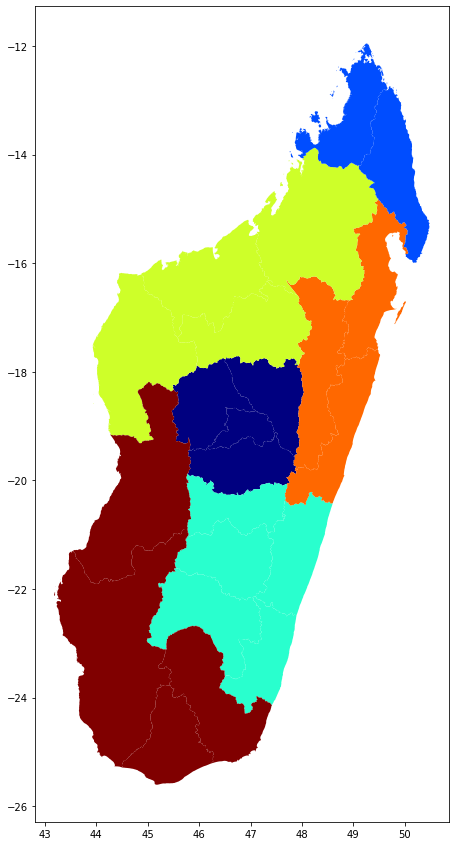

In [30]:
adm1.plot(column="old_provin", figsize=(15,15), cmap = 'jet')


The data inside collection adm1 is a bit too coarse for our area of interest, let's see what we find in adm2:

In [31]:
adm2 = geodb.get_collection_pg("adm2", database="madagascar_adm_boundaries")

In [32]:
adm2.head()

id                        created_at modified_at  \
0  239  2022-04-29T12:32:11.189736+00:00        None   
1  240  2022-04-29T12:32:11.189736+00:00        None   
2  241  2022-04-29T12:32:11.189736+00:00        None   
3  242  2022-04-29T12:32:11.189736+00:00        None   
4  243  2022-04-29T12:32:11.189736+00:00        None   

                                            geometry adm0_pcode     adm0_en  \
0  POLYGON ((47.50556 -18.89146, 47.50563 -18.891...         MG  Madagascar   
1  POLYGON ((47.55842 -18.91178, 47.55857 -18.911...         MG  Madagascar   
2  POLYGON ((47.51365 -18.87834, 47.51775 -18.879...         MG  Madagascar   
3  POLYGON ((47.50262 -18.91043, 47.50261 -18.910...         MG  Madagascar   
4  POLYGON ((47.53500 -18.85464, 47.53518 -18.854...         MG  Madagascar   

  adm1_pcode     adm1_en adm1_type   adm2_pcode             adm2_en adm2_type  \
0       MG11  Analamanga    Region  MG11101001A  1er Arrondissement  District   
1       MG11  Analamanga    Region  MG11101002A   2e Arrondissement  District   
2       MG11  Analamanga    Region  MG11101003A   3e Arrondissement  District   
3       MG11  Analamanga    Region  MG11101004A   4e Arrondissement  District   
4       MG11  Analamanga    Region  MG11101005A   5e Arrondissement  District   

   prov_code    old_provin                                 prov_type  \
0          1  Antananarivo  Old Provinces/Faritany dissolved in 2007   
1          1  Antananarivo  Old Provinces/Faritany dissolved in 2007   
2          1  Antananarivo  Old Provinces/Faritany dissolved in 2007   
3          1  Antananarivo  Old Provinces/Faritany dissolved in 2007   
4          1  Antananarivo  Old Provinces/Faritany dissolved in 2007   

                                               notes  \
0  Previous district name is Antananarivo Renivoh...   
1  Previous district name is Antananarivo Renivoh...   
2  Previous district name is Antananarivo Renivoh...   
3  Previous district name is Antananarivo Renivoh...   
4  Previous district name is Antananarivo Renivoh...   

                                              source  
0  Note that Communes (admin 3) have become the D...  
1  Note that Communes (admin 3) have become the D...  
2  Note that Communes (admin 3) have become the D...  
3  Note that Communes (admin 3) have become the D...  
4  Note that Communes (admin 3) have become the D...

We are interested in the administrative region of Antananarivo, which belongs to Analamanga. Here we select only the rows which belong to Analamanga.

In [33]:
adm2_Analamanga = geodb.get_collection("adm2", database="madagascar_adm_boundaries", query='adm1_en=eq.Analamanga')


In [34]:
adm2_Analamanga

id                        created_at modified_at  \
0   239  2022-04-29T12:32:11.189736+00:00        None   
1   240  2022-04-29T12:32:11.189736+00:00        None   
2   241  2022-04-29T12:32:11.189736+00:00        None   
3   242  2022-04-29T12:32:11.189736+00:00        None   
4   243  2022-04-29T12:32:11.189736+00:00        None   
5   244  2022-04-29T12:32:11.189736+00:00        None   
6   245  2022-04-29T12:32:11.189736+00:00        None   
7   246  2022-04-29T12:32:11.189736+00:00        None   
8   247  2022-04-29T12:32:11.189736+00:00        None   
9   248  2022-04-29T12:32:11.189736+00:00        None   
10  249  2022-04-29T12:32:11.189736+00:00        None   
11  250  2022-04-29T12:32:11.189736+00:00        None   
12  251  2022-04-29T12:32:11.189736+00:00        None   

                                             geometry adm0_pcode     adm0_en  \
0   POLYGON ((47.50556 -18.89146, 47.50563 -18.891...         MG  Madagascar   
1   POLYGON ((47.55842 -18.91178, 47.55857 -18.911...         MG  Madagascar   
2   POLYGON ((47.51365 -18.87834, 47.51775 -18.879...         MG  Madagascar   
3   POLYGON ((47.50262 -18.91043, 47.50261 -18.910...         MG  Madagascar   
4   POLYGON ((47.53500 -18.85464, 47.53518 -18.854...         MG  Madagascar   
5   POLYGON ((47.48436 -18.83989, 47.48491 -18.840...         MG  Madagascar   
6   POLYGON ((47.61521 -18.71709, 47.61702 -18.717...         MG  Madagascar   
7   POLYGON ((47.49982 -18.43546, 47.50490 -18.439...         MG  Madagascar   
8   POLYGON ((46.74249 -17.71321, 46.74325 -17.713...         MG  Madagascar   
9   POLYGON ((47.72437 -18.47394, 47.72465 -18.477...         MG  Madagascar   
10  POLYGON ((47.84665 -17.76164, 47.84740 -17.762...         MG  Madagascar   
11  POLYGON ((47.72871 -19.14659, 47.72961 -19.147...         MG  Madagascar   
12  POLYGON ((47.47574 -18.87596, 47.47633 -18.876...         MG  Madagascar   

   adm1_pcode     adm1_en adm1_type   adm2_pcode                    adm2_en  \
0        MG11  Analamanga    Region  MG11101001A         1er Arrondissement   
1        MG11  Analamanga    Region  MG11101002A          2e Arrondissement   
2        MG11  Analamanga    Region  MG11101003A          3e Arrondissement   
3        MG11  Analamanga    Region  MG11101004A          4e Arrondissement   
4        MG11  Analamanga    Region  MG11101005A          5e Arrondissement   
5        MG11  Analamanga    Region  MG11101006A          6e Arrondissement   
6        MG11  Analamanga    Region      MG11102    Antananarivo Avaradrano   
7        MG11  Analamanga    Region      MG11103             Ambohidratrimo   
8        MG11  Analamanga    Region      MG11104                   Ankazobe   
9        MG11  Analamanga    Region      MG11106             Manjakandriana   
10       MG11  Analamanga    Region      MG11107                 Anjozorobe   
11       MG11  Analamanga    Region      MG11115                Andramasina   
12       MG11  Analamanga    Region      MG11117  Antananarivo Atsimondrano   

   adm2_type  prov_code    old_provin  \
0   District          1  Antananarivo   
1   District          1  Antananarivo   
2   District          1  Antananarivo   
3   District          1  Antananarivo   
4   District          1  Antananarivo   
5   District          1  Antananarivo   
6   District          1  Antananarivo   
7   District          1  Antananarivo   
8   District          1  Antananarivo   
9   District          1  Antananarivo   
10  District          1  Antananarivo   
11  District          1  Antananarivo   
12  District          1  Antananarivo   

                                   prov_type  \
0   Old Provinces/Faritany dissolved in 2007   
1   Old Provinces/Faritany dissolved in 2007   
2   Old Provinces/Faritany dissolved in 2007   
3   Old Provinces/Faritany dissolved in 2007   
4   Old Provinces/Faritany dissolved in 2007   
5   Old Provinces/Faritany dissolved in 2007   
6   Old Provinces/Faritany dissolved in 2007   
7   Old Provinces/F

Let's take a bief look at a plot of our subset:

<AxesSubplot:>

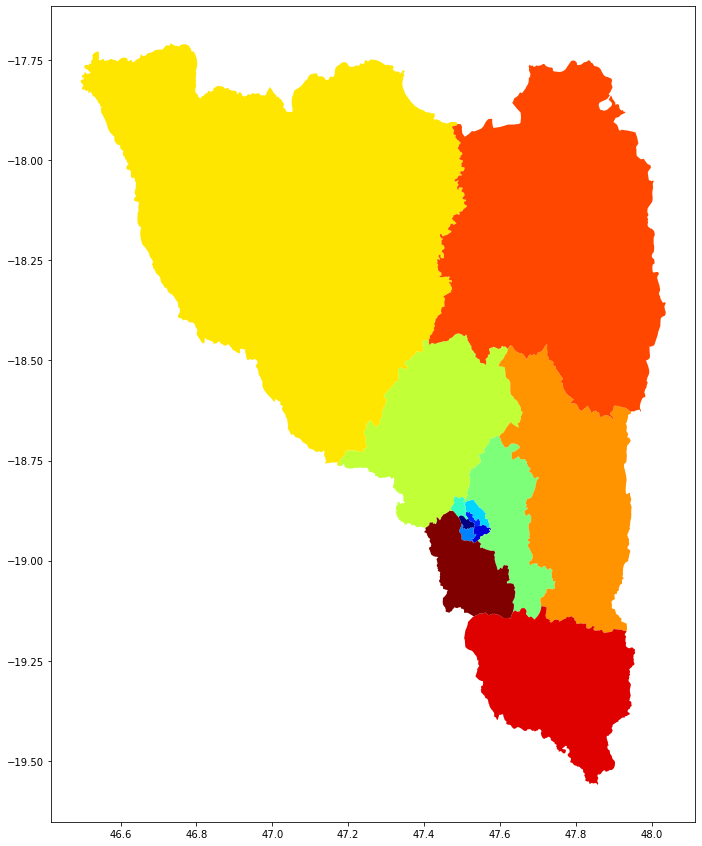

In [35]:
adm2_Analamanga.plot(figsize=(15,15), cmap = 'jet')

### Select regions to mask the cube

In [36]:
sub_Analamanga = adm2_Analamanga.loc[(adm2_Analamanga.adm2_en == "Antananarivo Atsimondrano") |
                                     (adm2_Analamanga.adm2_en == "Antananarivo Avaradrano") |
                                     (adm2_Analamanga.adm2_en == "Ambohidratrimo") |
                                     (adm2_Analamanga.adm2_en == "1er Arrondissement") |
                                     (adm2_Analamanga.adm2_en == "2e Arrondissement") |
                                     (adm2_Analamanga.adm2_en == "3e Arrondissement") |
                                     (adm2_Analamanga.adm2_en == "4e Arrondissement") |
                                     (adm2_Analamanga.adm2_en == "5e Arrondissement") |
                                     (adm2_Analamanga.adm2_en == "6e Arrondissement") ]

In [37]:
sub_Analamanga

id                        created_at modified_at  \
0   239  2022-04-29T12:32:11.189736+00:00        None   
1   240  2022-04-29T12:32:11.189736+00:00        None   
2   241  2022-04-29T12:32:11.189736+00:00        None   
3   242  2022-04-29T12:32:11.189736+00:00        None   
4   243  2022-04-29T12:32:11.189736+00:00        None   
5   244  2022-04-29T12:32:11.189736+00:00        None   
6   245  2022-04-29T12:32:11.189736+00:00        None   
7   246  2022-04-29T12:32:11.189736+00:00        None   
12  251  2022-04-29T12:32:11.189736+00:00        None   

                                             geometry adm0_pcode     adm0_en  \
0   POLYGON ((47.50556 -18.89146, 47.50563 -18.891...         MG  Madagascar   
1   POLYGON ((47.55842 -18.91178, 47.55857 -18.911...         MG  Madagascar   
2   POLYGON ((47.51365 -18.87834, 47.51775 -18.879...         MG  Madagascar   
3   POLYGON ((47.50262 -18.91043, 47.50261 -18.910...         MG  Madagascar   
4   POLYGON ((47.53500 -18.85464, 47.53518 -18.854...         MG  Madagascar   
5   POLYGON ((47.48436 -18.83989, 47.48491 -18.840...         MG  Madagascar   
6   POLYGON ((47.61521 -18.71709, 47.61702 -18.717...         MG  Madagascar   
7   POLYGON ((47.49982 -18.43546, 47.50490 -18.439...         MG  Madagascar   
12  POLYGON ((47.47574 -18.87596, 47.47633 -18.876...         MG  Madagascar   

   adm1_pcode     adm1_en adm1_type   adm2_pcode                    adm2_en  \
0        MG11  Analamanga    Region  MG11101001A         1er Arrondissement   
1        MG11  Analamanga    Region  MG11101002A          2e Arrondissement   
2        MG11  Analamanga    Region  MG11101003A          3e Arrondissement   
3        MG11  Analamanga    Region  MG11101004A          4e Arrondissement   
4        MG11  Analamanga    Region  MG11101005A          5e Arrondissement   
5        MG11  Analamanga    Region  MG11101006A          6e Arrondissement   
6        MG11  Analamanga    Region      MG11102    Antananarivo Avaradrano   
7        MG11  Analamanga    Region      MG11103             Ambohidratrimo   
12       MG11  Analamanga    Region      MG11117  Antananarivo Atsimondrano   

   adm2_type  prov_code    old_provin  \
0   District          1  Antananarivo   
1   District          1  Antananarivo   
2   District          1  Antananarivo   
3   District          1  Antananarivo   
4   District          1  Antananarivo   
5   District          1  Antananarivo   
6   District          1  Antananarivo   
7   District          1  Antananarivo   
12  District          1  Antananarivo   

                                   prov_type  \
0   Old Provinces/Faritany dissolved in 2007   
1   Old Provinces/Faritany dissolved in 2007   
2   Old Provinces/Faritany dissolved in 2007   
3   Old Provinces/Faritany dissolved in 2007   
4   Old Provinces/Faritany dissolved in 2007   
5   Old Provinces/Faritany dissolved in 2007   
6   Old Provinces/Faritany dissolved in 2007   
7   Old Provinces/Faritany dissolved in 2007   
12  Old Provinces/Faritany dissolved in 2007   

                                                notes  \
0   Previous district name is Antananarivo Renivoh...   
1   Previous district name is Antananarivo Renivoh...   
2   Previous district name is Antananarivo Renivoh...   
3   Previous district name is Antananarivo Renivoh...   
4   Previous district name is Antananarivo Renivoh...   
5   Previous district name is Antananarivo Renivoh...   
6                                                None   
7                                                None   
12                                               None   

                                               source  
0   Note that Communes (admin 3) have become the D...  
1   Note that Communes (admin 3) have become the D...  
2   Note that Communes (admin 3) have become the D...  
3   Note that Communes (admin 3) have become the D...  
4   Note that Communes (admin 3) have become the D...  
5   Note that Communes (admin 3) have becom

<AxesSubplot:>

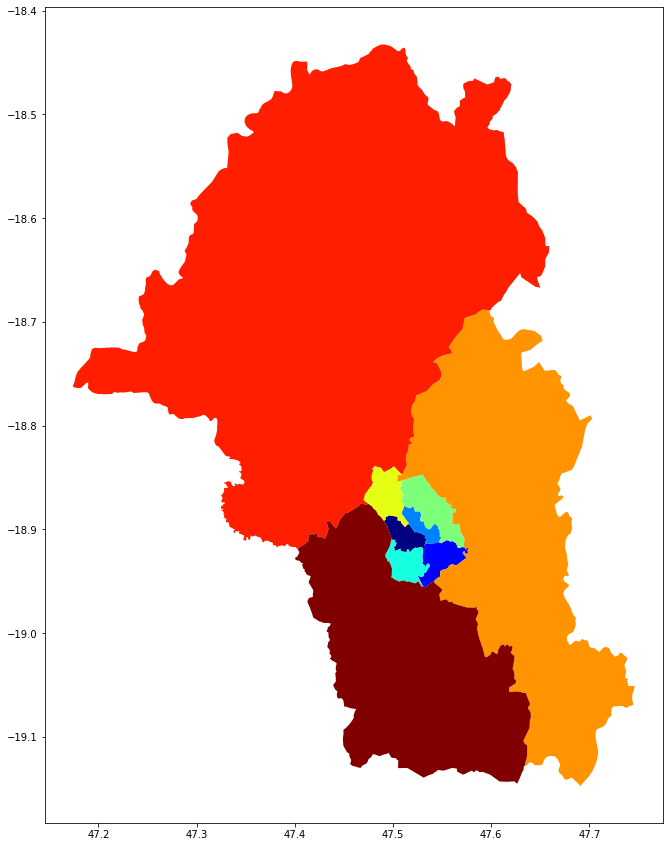

In [38]:
sub_Analamanga.plot(figsize=(15,15), cmap = 'jet')


Now we have selected only the rows which we are interested in. But they are in seperate geometry objects: 

In [39]:
sub_Analamanga.geometry

0     POLYGON ((47.50556 -18.89146, 47.50563 -18.891...
1     POLYGON ((47.55842 -18.91178, 47.55857 -18.911...
2     POLYGON ((47.51365 -18.87834, 47.51775 -18.879...
3     POLYGON ((47.50262 -18.91043, 47.50261 -18.910...
4     POLYGON ((47.53500 -18.85464, 47.53518 -18.854...
5     POLYGON ((47.48436 -18.83989, 47.48491 -18.840...
6     POLYGON ((47.61521 -18.71709, 47.61702 -18.717...
7     POLYGON ((47.49982 -18.43546, 47.50490 -18.439...
12    POLYGON ((47.47574 -18.87596, 47.47633 -18.876...
Name: geometry, dtype: geometry

Unify the subareas into one area of interest:

In [40]:
Antananarivo_region = shapely.ops.unary_union(geoms=[sub_Analamanga.geometry.iloc[i] for i in range(len(sub_Analamanga.geometry))])

In [41]:
# Plot the polygon on a map

IPython.display.GeoJSON(shapely.geometry.polygon.Polygon(Antananarivo_region).__geo_interface__)

<IPython.display.GeoJSON object>

Next, let's mask our dataset by the polygon we have just defined and visualise our 'masked' datacube.

In [42]:
s1_cube

<xarray.Dataset>
Dimensions:     (time: 8, lat: 1045, lon: 998, bnds: 2)
Coordinates:
  * lat         (lat) float64 -18.66 -18.66 -18.66 ... -19.13 -19.13 -19.13
  * lon         (lon) float64 47.22 47.22 47.22 47.22 ... 47.67 47.67 47.67
  * time        (time) datetime64[ns] 2022-01-03T02:19:35 ... 2022-03-28T02:1...
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    VV          (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    VV_dB       (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
    flood_mask  (time, lat, lon) float32 dask.array<chunksize=(1, 1045, 998), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S1GRD Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2022-05-19T16:40:45.536011
    time_coverage_start:     2022-01-03T02:19:35+00:00
    time_coverage_end:       2022-03-28T02:19:33+00:00
    time_coverage_duration:  P83DT23H59M58S
    geospatial_lon_min:      47.221985
    geospatial_lat_min:      -19.129599
    geospatial_lon_max:      47.671085
    geospatial_lat_max:      -18.659349
    processing_level:        L1B

Now we take a look at the data which is within our desired administrative boundaries. Therefore we mask the s1_cube:

In [43]:
water_antananarivo = mask_dataset_by_geometry(s1_cube, geometry=Antananarivo_region)

Let's visualise our masked data cube using the timestep on 27th January and the VV_dB variable:

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


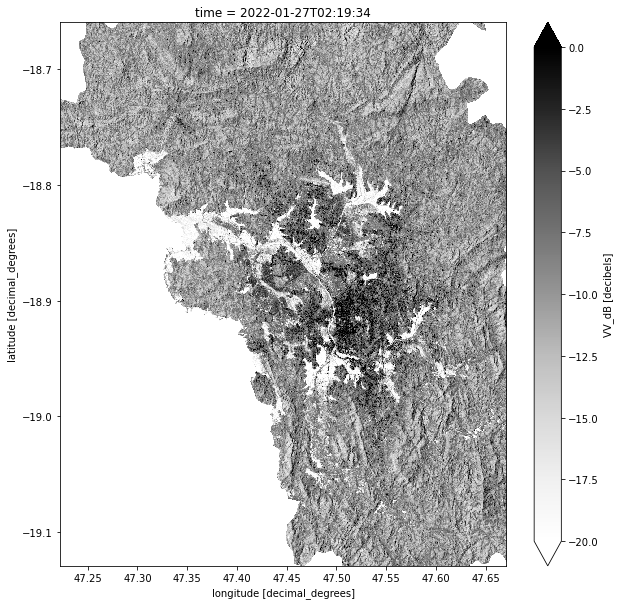

In [44]:
water_antananarivo.VV_dB.isel(time=2).plot.imshow(cmap='Greys', vmin=-20, vmax=0, figsize=(10, 10))
plt.show()

OK, this looks good. Now we are going to calculate the mean VV dB polarisation across the area for each time step. Firstly, we want to calculate the mean VV_dB on axis 1 (lat) and 2 (lon). The second function removes any observations with values of 0 (observations that don't cover our area of interest).

In [45]:
# calculate the mean VV dB for each time step
timeseriesVV_dB = water_antananarivo.VV_dB.mean(axis=(1,2), skipna=True)

# remove any observations with no data
timeseriesVV_dB = timeseriesVV_dB.where(timeseriesVV_dB !=0).dropna("time")

# return the new data cube chunk
timeseriesVV_dB

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'VV_dB' (time: 8)>
dask.array<where, shape=(8,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-01-03T02:19:35 ... 2022-03-28T02:19:33

Next we can plot this new array we have generated. The result is an excellent time series plot showing the two flood events that occured in the time period. We can see the larger picture as this is the mean value over several pixels rather than just a single point like we previously plotted.

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


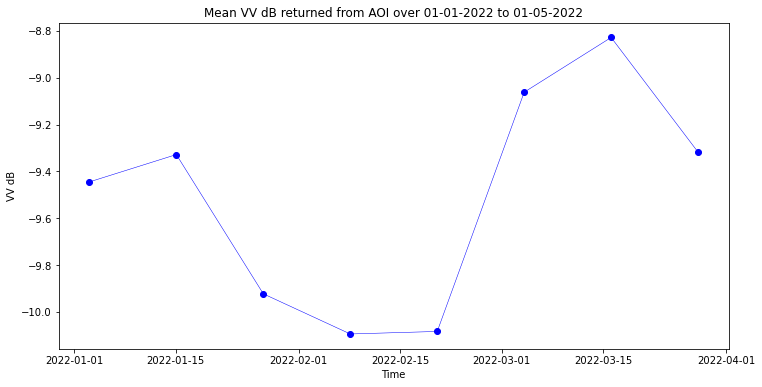

In [46]:
# Plot VV_dB timeseries
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(timeseriesVV_dB.time, timeseriesVV_dB, color="blue", marker="o", linewidth=0.5)
ax.set_title("Mean VV dB returned from AOI over 01-01-2022 to 01-05-2022")
ax.set_xlabel('Time')
ax.set_ylabel('VV dB')
plt.show()

In the time series plot generated from averaged VV_dB values over the selected region, the two separate flooding events appear appear as one longer period with surface flooding that stretches from mid January to early March 2022.

## Creating advanced variables

### Mapping flooding frequency across the whole AOI

We can utilise the generated water mask to calculate the flooding frequency proportionate to the overall number of observations. Since the flood mask is a binary layer, we just need to calculate the sum of all flooded observations for each pixel and divide it by the total number (count) of observations.

In [47]:
flood_sum = s1_cube.flood_mask.sum(dim="time")
flood_count = s1_cube.flood_mask.count(dim="time")
flood_average = flood_sum / flood_count

flood_average.attrs['long_name'] = 'flood_average'
flood_average.attrs['units'] = 'nounits'

s1_cube['flood_average'] = flood_average

Now let's plot the flood_average into a plot:

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


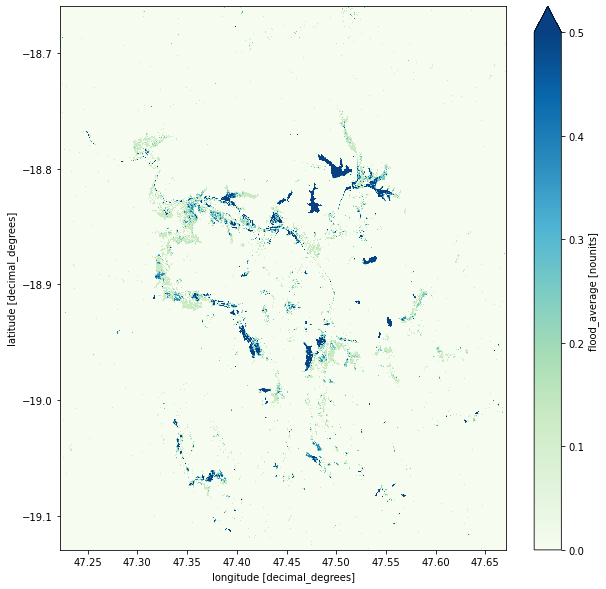

In [48]:
flood_average.plot.imshow(cmap='GnBu', vmin=0, vmax=0.5, figsize=(10, 10))
plt.show()

For our end product, we have visualised the flood plain extent very clearly here and can also identify some areas that are more susceptible to flooding than others. Added value products like this flood average map enable policy makers to make more informed decisions, 

## Export a variable to GeoTiff

Finally we will export some of the variables we have generated in this notebook. This is really easy to do and is shown in the next cell:

In [49]:
# define the timestep you wish to export
timestep = flood_threshold2_step2.sel(time='2022-01-27 10:00:00', method='nearest')

# define projection
timestep_wgs84 = timestep.rio.write_crs("epsg:4326")

# write to raster
timestep_wgs84.rio.to_raster("flood_extent_20220127.tif")

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


Now let's export the flood_average variable which is even easier to do as we don't need to select a single timestamp.

In [50]:
# define projection
flood_average_wgs84 = flood_average.rio.write_crs("epsg:4326")

# write to raster
flood_average_wgs84.rio.to_raster("flood_average.tif")

/opt/conda/envs/eurodatacube-2022.02/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
